## Table of Contents
- [Introduction](#Introduction)
    - [Imports](#Imports)
    - [Data Wrangling](#Data-Wrangling)
- [Preprocessing](#Preprocessing)
    - [Transformers](#Transformers)
- [Linear Models](#Linear-Models)
    - [Ridge Regression](#Ridge-Regression)
    - [Elastic Net](#Elastic-Net)
- [Tree Based Models](#Tree-Based-Models)
    - [Random Forest](#Random-Forest)
    - [XGBoost](#XGBoost)
- [Comparing RMSE of XGBoost and Random Forest](#Comparing-RMSE-of-XGBoost-and-Random-Forest)
- [Feature Importances and Directionality](#Feature-Importances-and-Directionality)
- [Visualizations](#Visualizations)

- [Horror Movie only](#Horror-Movie-only)
    - [Feature Importances and Directionality for Horror Only](#Feature-Importances-and-Directionality-for-Horror-Only)

# Introduction

In this notebook, we will try to predict a movie's return on investment using various models, and assess the 
performance of each model as well as obtaining actionable insights from the models.

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error 
from sklearn.compose import ColumnTransformer
from xgboost import XGBRegressor



## Data Wrangling

In [2]:
data = pd.read_csv('domestic_boxoffice.csv', encoding='latin-1')
data = data.drop(['Title', 'Year', 'Release Date', 'Profit (millions)', 'Domestic Gross (millions)'], axis=1)
# Some wrangling
known_genres = data[data['Genre'].str.contains('Unknown') == False]
split_genres = known_genres['Genre'].str.split(' ', expand=True)
known_genres['Genre 1'] = split_genres.loc[:, 0]
known_genres['Genre 2'] = split_genres.loc[:, 1] 
genre_1_df = known_genres.drop(['Genre', 'Genre 2'], axis=1)
genre_1_df.columns = ['Genre' if col =='Genre 1' else col for col in genre_1_df.columns]
genre_2_df = known_genres.drop(['Genre', 'Genre 1'], axis=1)
genre_2_df.columns = ['Genre' if col =='Genre 2' else col for col in genre_2_df.columns]

df = pd.concat([genre_1_df, genre_2_df], sort=False).reset_index(drop=True)
df = df.dropna(subset=['Rating', 'Genre', 'Domestic ROI Multiplier'])
df = df.loc[~((df.Rating=='Unrated') | (df.Rating=='UNRATED') | (df.Rating=='Not Rated') | (df.Rating=='NOT RATED') | 
              (df.Rating=='Approved') | (df.Rating=='APPROVED')), :]
df['Domestic ROI Multiplier'] = np.log(df['Domestic ROI Multiplier'])

/Users/benisonp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/benisonp/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


# Preprocessing

In [3]:
y = df['Domestic ROI Multiplier'] 
X = df.drop('Domestic ROI Multiplier', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Transformers

In [4]:
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), 
                                     ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(['Domestic ROI Multiplier'], axis=1).columns
categorical_features = df.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features),
                                              ('cat', categorical_transformer, categorical_features)])

# Linear Models

## Ridge Regression

In [5]:
pipeline_ridge = Pipeline(steps=[('preprocessor', preprocessor), ('ridge', Ridge())])
parameters = {'ridge__alpha':np.linspace(1,100, 20)}
# Tune parameters
gm_cv = GridSearchCV(pipeline_ridge, parameters, cv = 4)
# Fit pipeline to training set
gm_cv.fit(X_train, y_train)
# Compute and print the metrics
r2 = gm_cv.score(X_test, y_test)
print("Tuned Ridge Alpha: {}".format(gm_cv.best_params_))
print("Tuned Ridge R squared: {}".format(r2))

Tuned Ridge Alpha: {'ridge__alpha': 11.421052631578947}
Tuned Ridge R squared: 0.1775662776599889


## Elastic Net 

In [6]:
pipeline_elastic = Pipeline(steps=[('preprocessor', preprocessor), ('elasticnet', ElasticNet())])
parameters = {'elasticnet__l1_ratio':np.linspace(0.05,0.1,10), 'elasticnet__alpha':np.linspace(0.01,1, 20)}
# Tune parameters
gm_cv = GridSearchCV(pipeline_elastic, parameters, cv = 4)
# Fit pipeline to training set
gm_cv.fit(X_train, y_train)
# Compute and print the metrics
r2 = gm_cv.score(X_test, y_test)
print("Tuned ElasticNet Parameters: {}".format(gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))

Tuned ElasticNet Parameters: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.05}
Tuned ElasticNet R squared: 0.17598209380490082


# Tree Based Models

## Random Forest

In [8]:
pipeline_forest = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor())])
parameters = {'regressor__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
            'regressor__max_depth': [10, 20, 30, 40, 50],
            'regressor__max_features': ['auto', 'sqrt']}
rf_cv = GridSearchCV(pipeline_forest, parameters, cv=4)
rf_cv.fit(X_train, y_train)

print("The best number of estimators is {}".format(rf_cv.best_params_['regressor__n_estimators']))
print("The best max depth is {}".format(rf_cv.best_params_['regressor__max_depth']))
print("The best approach to max_features is {}".format(rf_cv.best_params_['regressor__max_features']))


The best number of estimators is 600
The best max depth is 30
The best approach to max_features is auto


### Random Forest with tuned hyperparameters

In [15]:
tuned_pipeline_forest = Pipeline(steps=[('preprocessor', preprocessor), 
                                  ('regressor', RandomForestRegressor(n_estimators=600, max_features='auto', 
                                                                     max_depth=30))])
tuned_pipeline_forest.fit(X_train, y_train)
importances = tuned_pipeline_forest.named_steps['regressor'].feature_importances_ # Extract feature importances

## XGBoost

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', XGBRegressor())])
params = {'regressor__objective':['reg:squarederror'],
          'regressor__colsample_bytree': np.arange(0.2, 0.5, 0.05),
          'regressor__learning_rate': np.arange(0, 1, 0.1),
          'regressor__max_depth': np.arange(3, 10, 1), 
          'regressor__alpha': np.arange(1, 10, 0.5)}

xgb_cv = RandomizedSearchCV(pipeline_xgb, params, cv=4, scoring='neg_mean_squared_error')
xgb_cv.fit(X_train, y_train)
# Retrieve feature importances from XGBoost
xgb_feature_importances = xgb_cv.best_estimator_.named_steps['regressor'].feature_importances_

print(xgb_cv.best_params_)


{'regressor__objective': 'reg:squarederror', 'regressor__max_depth': 8, 'regressor__learning_rate': 0.1, 'regressor__colsample_bytree': 0.39999999999999997, 'regressor__alpha': 1.0}


### XGBoost with tuned hyperparameters

In [21]:
tuned_pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor), 
                                     ('regressor', XGBRegressor(learning_rate=0.1, colsample_bytree=0.3999, 
                                                               alpha=1.0, max_depth=8, objective='reg:squarederror'))])
tuned_pipeline_xgb.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('imputer', SimpleImputer(copy=True, fill_value=None, missing_values=nan,
       strategy='median', verbo...lpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1))])

## Comparing RMSE of XGBoost and Random Forest

In [131]:
medianpred = np.median(df['Domestic ROI Multiplier'])
baseline_pred = [medianpred] * len(y_test)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
print("The RMSE for a naive model is {}".format(baseline_rmse))

rf_ypred = tuned_pipeline_forest.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_ypred))
print("The RMSE of the Random Forest model is {}".format(rf_rmse))

xgb_ypred = tuned_pipeline_xgb.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_ypred))
print("The RMSE of the XGBoost model is {}".format(xgb_rmse))

The RMSE for a naive model is 1.2525765126107868
The RMSE of the Random Forest model is 0.9352655019358237
The RMSE of the XGBoost model is 0.9563101801179906


Compared to the naive model, which predicts the median ROI in all cases, both the random forest and XGBoost do well.
Between the Random Forest and XGBoost model, both have similar RMSEs, but because the Random Forest RMSE is just a 
little bit lower, we will go with this model moving forward.

## Feature Importances and Directionality

In [112]:
# Minor wrangling to create dataset with feature names and linear coefficients
num_features = list(numeric_features) # Creating list of numeric features to which we will append the categorical features
onehot_features = tuned_pipeline_forest.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names()
for item in onehot_features:
    num_features.append(item)
feature_names = num_features.copy() # List of feature names
feature_names = [name.split('_')[1] if '_' in name else name for name in feature_names]

elasticnet_coefs = gm_cv.best_estimator_.named_steps['elasticnet'].coef_
elasticnet_df = pd.DataFrame({"Feature Names": feature_names, 
                           "Coefficients":elasticnet_coefs}) 
feature_importance_df = pd.DataFrame({"Feature Names": feature_names,
                                     "Random Forest Importances":importances,
                                     "XGB Importances":xgb_feature_importances})
feature_importance_coef_df = pd.merge(feature_importance_df, elasticnet_df, how='inner', on ='Feature Names')
rf_feature_df = feature_importance_coef_df.sort_values(by="Random Forest Importances", ascending=False)
print(rf_feature_df[['Feature Names', 'Random Forest Importances', 'Coefficients']].head(n=10)) # Top 10 features of importance

        Feature Names  Random Forest Importances  Coefficients
0   Budget (millions)                   0.232363     -0.153137
4            RT score                   0.177266      0.301591
1             Runtime                   0.111755     -0.028778
2           Metascore                   0.108264     -0.064059
3          IMDB score                   0.103535      0.211299
9                   R                   0.024482     -0.286321
29              Drama                   0.018343     -0.229743
20            October                   0.017277     -0.235682
21          September                   0.014167     -0.178666
34             Horror                   0.013837      0.724080


# Visualizations

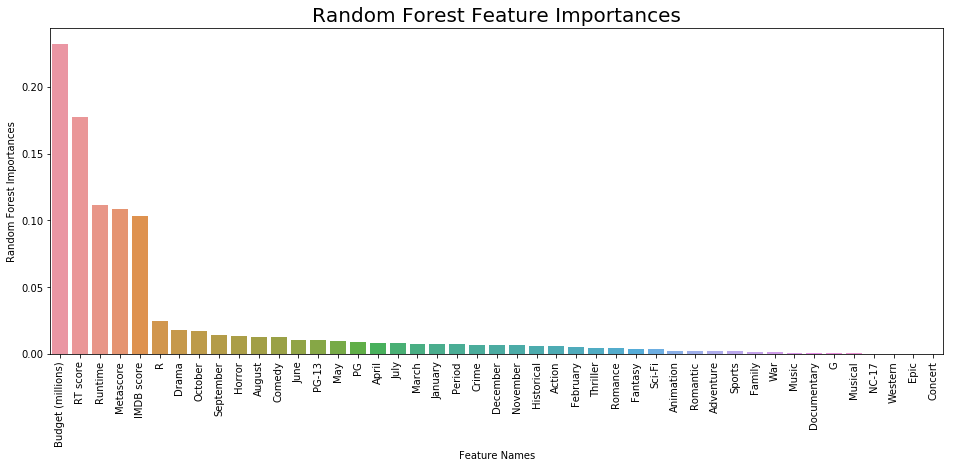

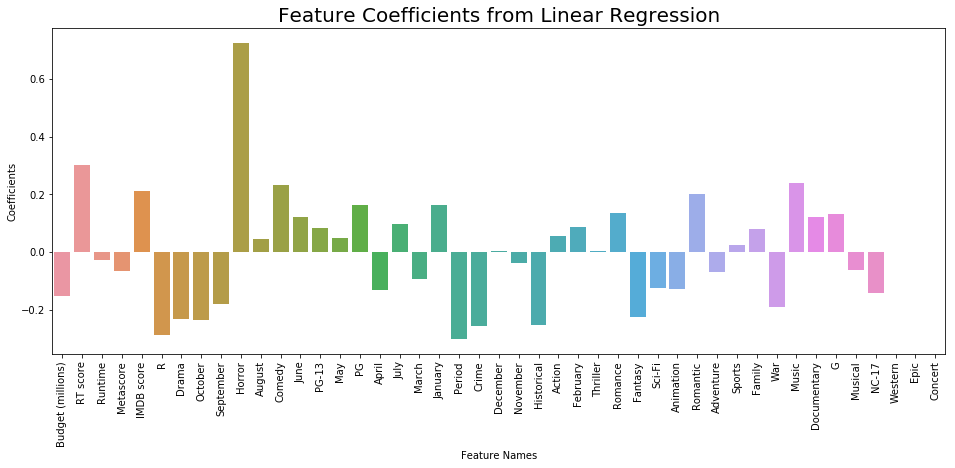

In [133]:
plt.figure(figsize=(16, 6))
sns.barplot(data=rf_feature_df, x='Feature Names', y='Random Forest Importances')
plt.xticks(rotation=90)
plt.title("Random Forest Feature Importances", size=20)
plt.savefig('Random Forest Feature Importances.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 6))
sns.barplot(data=rf_feature_df, x='Feature Names', y='Coefficients')
plt.xticks(rotation=90)
plt.title("Feature Coefficients from Linear Regression", size=20)
plt.savefig('Feature Coefficients from Linear Regression.png', bbox_inches='tight')
plt.show()



# Horror Movie only

In [54]:
horror_df = df[df.Genre=='Horror']

# Preprocessing of data 
y_horror = horror_df['Domestic ROI Multiplier'] 
X_horror = horror_df.drop('Domestic ROI Multiplier', axis=1)
X_train_horror, X_test_horror, y_train_horror, y_test_horror = train_test_split(X_horror, y_horror, 
                                                                                test_size=0.3, random_state=42)

numeric_features_horror = horror_df.select_dtypes(include=['int64', 'float64']).drop(['Domestic ROI Multiplier'], axis=1).columns
categorical_features_horror = horror_df.select_dtypes(include=['object']).columns

preprocessor_horror = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features_horror),
                                              ('cat', categorical_transformer, categorical_features_horror)])

## Elastic Net - Horror only

In [92]:
pipeline_elastic_horror = Pipeline(steps=[('preprocessor', preprocessor_horror), ('elasticnet', ElasticNet())])
parameters = {'elasticnet__l1_ratio':np.linspace(0.05,0.1,10), 'elasticnet__alpha':np.linspace(0.01,1, 20)}
# Tune parameters
gm_cv_horror = GridSearchCV(pipeline_elastic_horror, parameters, cv = 4)
# Fit pipeline to training set
gm_cv_horror.fit(X_train_horror, y_train_horror)
# Compute and print the metrics
r2 = gm_cv_horror.score(X_test_horror, y_test_horror)

print("Tuned ElasticNet Parameters: {}".format(horror_gm_cv.best_params_))
print("Tuned ElasticNet R squared: {}".format(r2))

Tuned ElasticNet Parameters: {'elasticnet__alpha': 0.21842105263157896, 'elasticnet__l1_ratio': 0.07777777777777778}
Tuned ElasticNet R squared: 0.32683305835108334


In [79]:
## Random Forest - Horror Only
pipeline_forest_horror = Pipeline(steps=[('preprocessor', preprocessor_horror), ('regressor', RandomForestRegressor())])
parameters = {'regressor__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
            'regressor__max_depth': [10, 20, 30, 40, 50],
            'regressor__max_features': ['auto', 'sqrt']}
rf_cv_horror = GridSearchCV(pipeline_forest_horror, parameters, cv=4)
rf_cv_horror.fit(X_train_horror, y_train_horror)

print("The best number of estimators is {}".format(rf_cv_horror.best_params_['regressor__n_estimators']))
print("The best max depth is {}".format(rf_cv_horror.best_params_['regressor__max_depth']))
print("The best approach to max_features is {}".format(rf_cv_horror.best_params_['regressor__max_features']))

The best number of estimators is 1000
The best max depth is 20
The best approach to max_features is sqrt


In [86]:
## XGBoost - Horror only
pipeline_xgb_horror = Pipeline(steps=[('preprocessor', preprocessor_horror), ('regressor', XGBRegressor())])
params = {'regressor__objective':['reg:squarederror'],
          'regressor__colsample_bytree': np.arange(0.2, 0.5, 0.05),
          'regressor__learning_rate': np.arange(0, 1, 0.1),
          'regressor__max_depth': np.arange(3, 10, 1), 
          'regressor__alpha': np.arange(1, 10, 0.5)}

xgb_cv_horror = RandomizedSearchCV(pipeline_xgb_horror, params, cv=4, scoring='neg_mean_squared_error')
xgb_cv_horror.fit(X_train_horror, y_train_horror)
print(xgb_cv_horror.best_params_)

{'regressor__objective': 'reg:squarederror', 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__colsample_bytree': 0.35, 'regressor__alpha': 5.5}


## Comparing XGBoost to Random Forest for Horror only

In [132]:
medianpred = np.median(horror_df['Domestic ROI Multiplier'])
baseline_pred_horror = [medianpred] * len(y_test_horror)
baseline_rmse_horror = np.sqrt(mean_squared_error(y_test_horror, baseline_pred_horror))
print("The RMSE for a naive model is {}".format(baseline_rmse_horror))

rf_ypred_horror = rf_cv_horror.best_estimator_.predict(X_test_horror)
rf_rmse_horror = np.sqrt(mean_squared_error(y_test_horror, rf_ypred_horror))
print("The RMSE of the Random Forest model is {}".format(rf_rmse_horror))

xgb_ypred_horror = xgb_cv_horror.best_estimator_.predict(X_test_horror)
xgb_rmse_horror = np.sqrt(mean_squared_error(y_test_horror, xgb_ypred_horror))
print("The RMSE of the XGBoost model is {}".format(xgb_rmse_horror))

The RMSE for a naive model is 1.7986661471315193
The RMSE of the Random Forest model is 1.3733157410460062
The RMSE of the XGBoost model is 1.4656617361039108


In this case, Random Forest still performs better than the XGBoost model.

# Feature Importances and Directionality for Horror Only

In [114]:
rf_importances_horror = rf_cv_horror.best_estimator_.named_steps['regressor'].feature_importances_
xgb_feature_importances_horror = xgb_cv_horror.best_estimator_.named_steps['regressor'].feature_importances_
elasticnet_coefs_horror = horror_gm_cv.best_estimator_.named_steps['elasticnet'].coef_

# Create list of feature names from the horror dataset
horror_num_features = list(numeric_features) # Creating list of numeric features to which we will append the categorical features
onehot_features_horror = rf_cv_horror.best_estimator_.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names()
for item in onehot_features_horror:
    horror_num_features.append(item)
feature_names_horror = horror_num_features.copy() # List of feature names
feature_names_horror = [name.split('_')[1] if '_' in name else name for name in feature_names_horror]

# Create dataframes and merge
elasticnet_horror_coefs = gm_cv_horror.best_estimator_.named_steps['elasticnet'].coef_
elasticnet_df_horror = pd.DataFrame({"Feature Names": feature_names_horror, 
                           "Coefficients":elasticnet_horror_coefs}) 
feature_importance_df_horror = pd.DataFrame({"Feature Names": feature_names_horror,
                                     "Random Forest Importances":rf_importances_horror,
                                     "XGB Importances":xgb_feature_importances_horror})
feature_importance_coef_df_horror = pd.merge(feature_importance_df_horror, elasticnet_df_horror, 
                                      how='inner', on ='Feature Names')

rf_feature_df_horror = feature_importance_coef_df_horror.sort_values(by="Random Forest Importances", ascending=False).reset_index()
xgb_feature_df_horror = feature_importance_coef_df_horror.sort_values(by='XGB Importances', ascending=False).reset_index()

print(rf_feature_df_horror[['Feature Names', 'Random Forest Importances', 'Coefficients']].head(n=10)) 
print(xgb_feature_df_horror[['Feature Names', 'XGB Importances', 'Coefficients']].head(n=10)) 

       Feature Names  Random Forest Importances  Coefficients
0  Budget (millions)                   0.320475     -0.400081
1            Runtime                   0.157215     -0.296154
2          Metascore                   0.145168      0.286815
3           RT score                   0.129578      0.084170
4         IMDB score                   0.106708      0.191700
5            October                   0.024084      0.091972
6               July                   0.015896      0.081523
7          September                   0.015209     -0.000000
8              March                   0.013217     -0.152784
9              PG-13                   0.012737      0.097598
       Feature Names  XGB Importances  Coefficients
0  Budget (millions)         0.220108     -0.400081
1            Runtime         0.100603     -0.296154
2         IMDB score         0.085250      0.191700
3           RT score         0.079102      0.084170
4              March         0.076074     -0.152784
5     